# ROC Curve Performance Analysis

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
from joblib import load
from sklearn.metrics import roc_curve
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [2]:
version = '7.0.2'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = df = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = df = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

In [75]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}_tune')
old_nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'OLDNN': old_nn}

In [41]:
# Define custom performance metric so that closer to 0 is better!
def roc_metric(T, F, k=10):
    # T = true positive rate
    # F = 1 - False positive rate
    metric = np.sqrt((1-T)**2+(1-F)**2) + k*np.abs(T-F)
    max_at = np.argmin(metric)
    return np.min(metric), T[max_at], F[max_at]

# Model Performance Across Sets

In [76]:
test_model = 'RFC'

In [77]:
roc_data = []
for dataset in [train, val, test]:
    roc = roc_curve(dataset['category'], models[test_model].predict_proba(dataset.drop(['category', 'Lb_M', 'IsSimulated'], axis=1))[:,1])
    roc_data.append([roc[1], 1-roc[0]])

Train
True Positive Rate: 0.9557
False Positive Rate: 0.9557

Val
True Positive Rate: 0.9381
False Positive Rate: 0.9382

Test
True Positive Rate: 0.9353
False Positive Rate: 0.9353



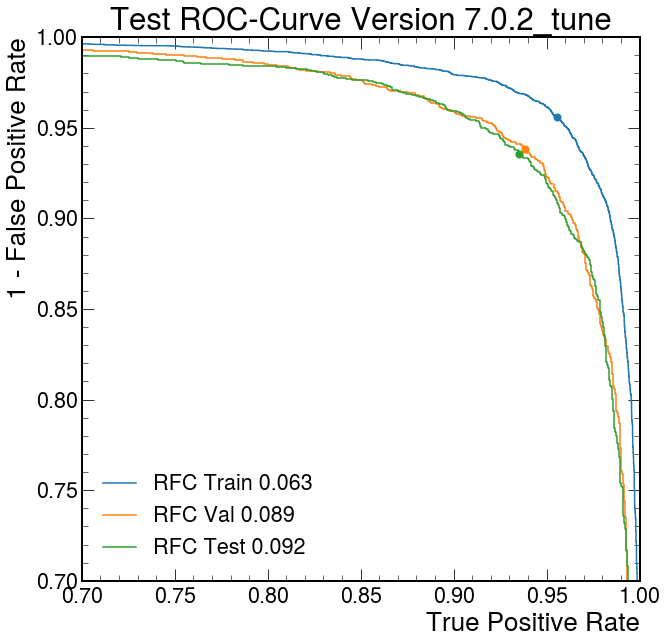

In [78]:
fig, ax = plt.subplots(1, 1)
datasets = ['train', 'val', 'test']
for i, j in enumerate(roc_data):
    best_metric = roc_metric(j[0], j[1])
    print(f'{datasets[i].capitalize()}\n============\nTrue Positive Rate: {best_metric[1]:.4f}\nFalse Positive Rate: {best_metric[2]:.4f}\n')
    ax.plot(j[0], j[1], label=f'{test_model} {datasets[i].capitalize()} {best_metric[0]:.3f}')
    ax.scatter(best_metric[1], best_metric[2], marker='o', s=50)
ax.set_xlim(0.7, 1)
ax.set_ylim(0.7, 1)
plt.ylabel('1 - False Positive Rate')
plt.xlabel('True Positive Rate')
plt.legend(loc='lower left')
plt.title(f'Test ROC-Curve Version {version}_tune')
plt.savefig(f'../images/ModelEval/{test_model}_ROC_{version}_Tune.png', dpi=800)
plt.show()

# Mega ROC Curve
Test data ROC across all models zoomed in. Best positions marked and $\zeta$ values given.

In [ ]:
roc_data = []
for name, model in models.items():
    try:
        roc = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    except:
        roc = roc_curve(y_test, model.predict(X_test))
    roc_data.append([roc[1], 1-roc[0]])

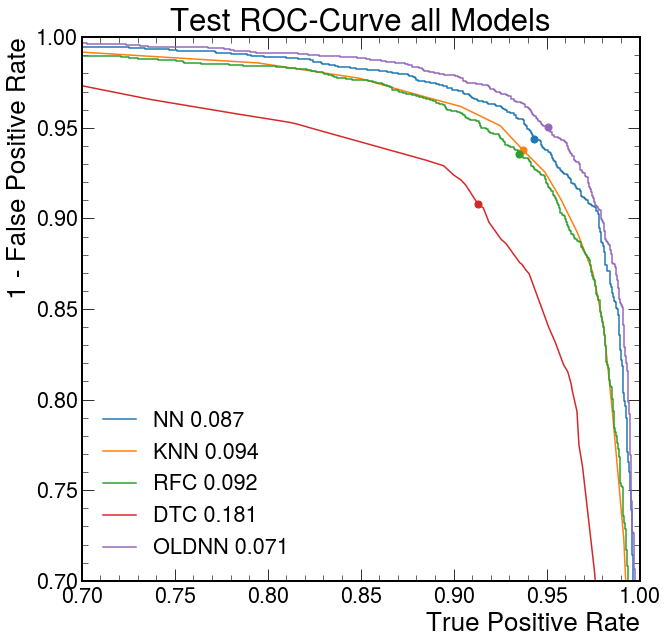

In [81]:
fig, ax = plt.subplots(1, 1)
for i, j in enumerate(roc_data):
    best_metric = roc_metric(j[0], j[1])
    ax.plot(j[0], j[1], label=f'{list(models.keys())[i]} {best_metric[0]:.3f}')
    ax.scatter(best_metric[1], best_metric[2], marker='o', s=50)
ax.set_xlim(0.7, 1)
ax.set_ylim(0.7, 1)
plt.ylabel('1 - False Positive Rate')
plt.xlabel('True Positive Rate')
plt.legend(loc='lower left')
plt.title(f'Test ROC-Curve all Models')
plt.savefig(f'../images/ModelEval/All_ROC_Test_Tune.png', dpi=800)
plt.show()